Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (228, 85, 121)
Shape of input data: (10285, 228) [flattened space x time snapshots]


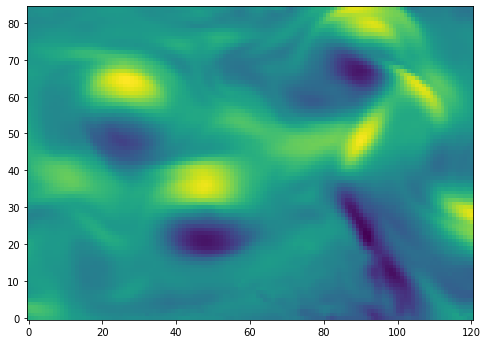

In [127]:
# proper orthogonal decomposition (POD)
import os
import modred as mr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# set area
area="GoM"
if area == "area1":
    # Area 1
    data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
    files = os.listdir(data_dir)
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-140, -120), latitude=slice(15,32))
elif area == "GoM":
    # GoM
    data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/GoM"
    files = os.listdir(data_dir)
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-95, -85), latitude=slice(22,29))

print(f"Percentage of NaN values: {int(100*np.isnan(data['utotal']).sum()/np.prod(data['utotal'].shape))}%")
data = data["utotal"].squeeze()
print(f"Data dims: {data.dims}, data shape: {data.values.shape}")
data = data.values
data_shape = data.shape

# plot one snapshot
fig = plt.figure(figsize=(8, 8))
plt.imshow(data[0], origin="lower")

# reshape data (flattened snapshots vs time -> 2d array)
data = data.reshape(data.shape[0], -1).T
print(f"Shape of input data: {data.shape} [flattened space x time snapshots]")

# compute POD
num_modes = 6
POD_res = mr.compute_POD_arrays_snaps_method(data, list(mr.range(num_modes)))
# POD_res = mr.compute_POD_arrays_direct_method(data, list(mr.range(num_modes)))
modes = POD_res.modes
eigvals = POD_res.eigvals
proj_coeffs = POD_res.proj_coeffs

assert eigvals.all() == np.array(sorted(eigvals)).all(), "Eigenvalues not sorted"

In [126]:
# save all frames of original data to make gif
for i in range(data.shape[1]):
    plt.imsave(f"/home/jonas/Downloads/plots/data_gif/{str(i).zfill(4)}.png", data[:, i].reshape(data_shape[1:]), origin="lower")

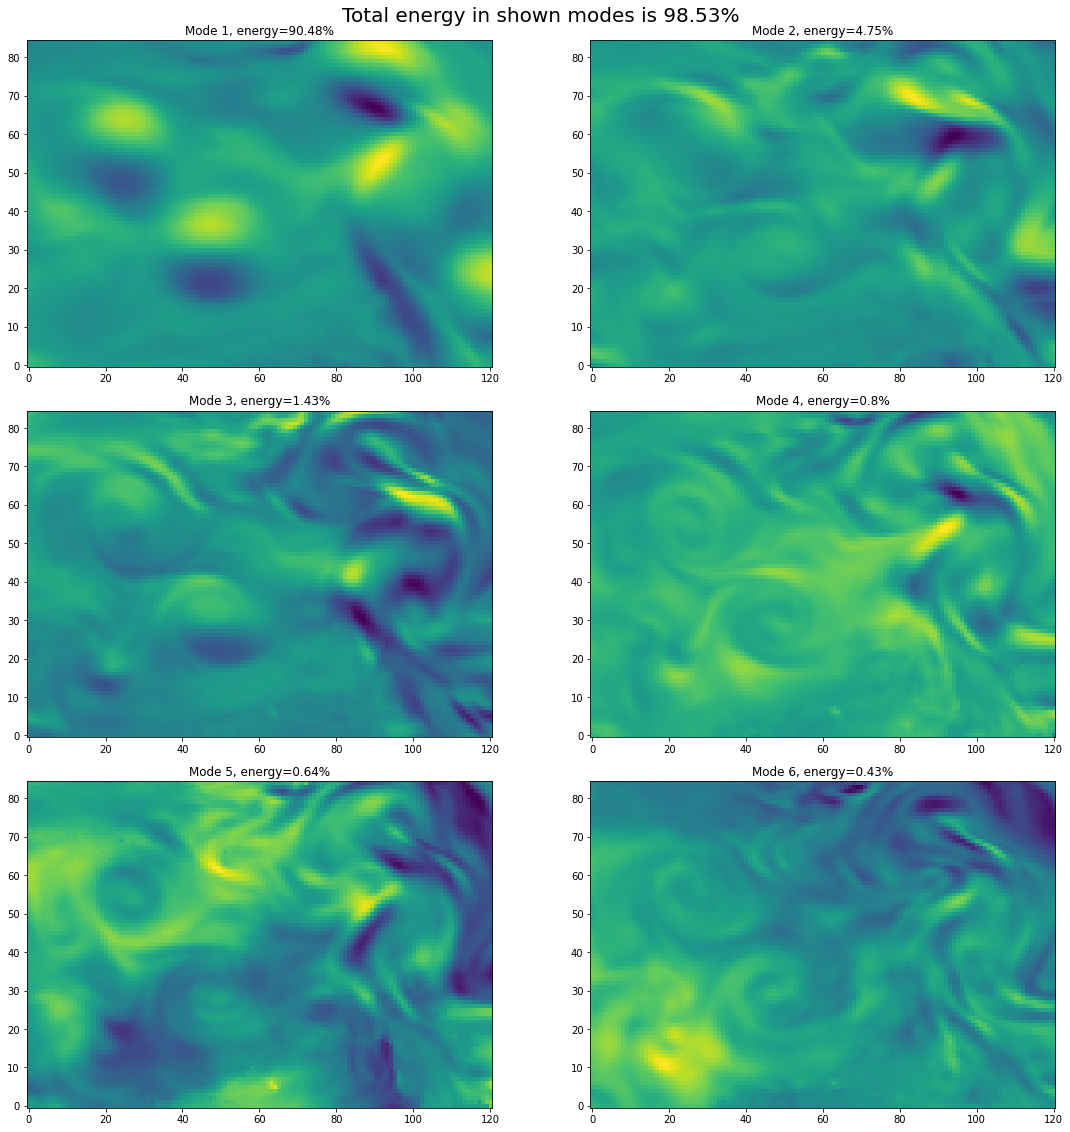

In [183]:
sum_eigvals = eigvals.sum()
normalized_eigvals = eigvals/sum_eigvals

fig, axs = plt.subplots(int(modes.shape[1]/2), 2, figsize=(16, 16))
for i in range(modes.shape[1]):
    ax = axs[int(i//2), i%2]
    ax.imshow(modes[:, i].reshape(data_shape[1:]), origin="lower")
    ax.set_title(f"Mode {i+1}, energy={round(normalized_eigvals[i]*100, 2)}%")
fig.suptitle(f"Total energy in shown modes is {round(normalized_eigvals[:modes.shape[1]].sum()*100, 2)}%", fontsize=20)
plt.tight_layout()
plt.show()

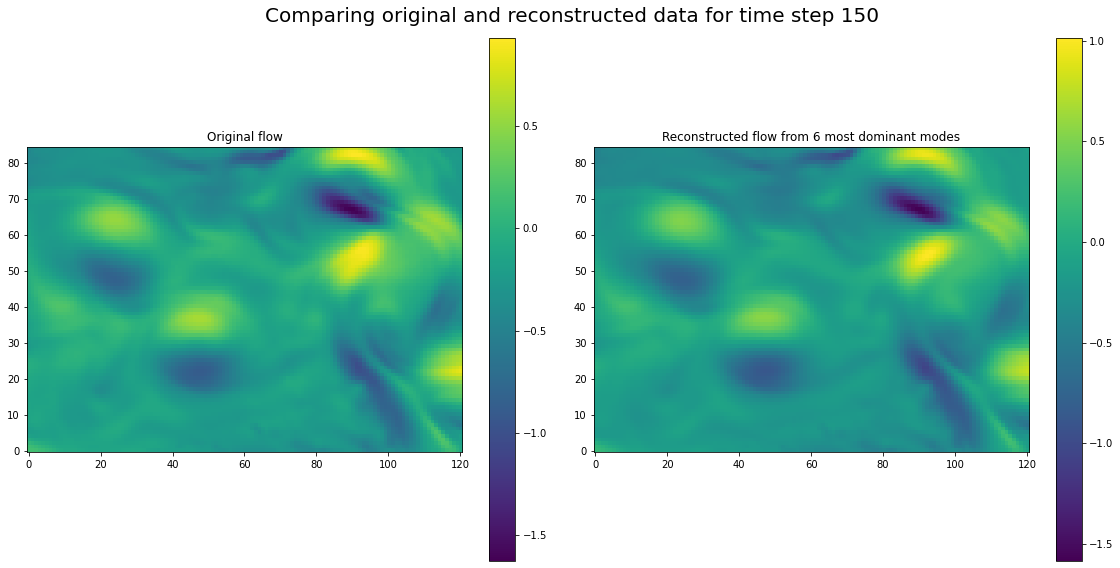

In [189]:
time_step = 150

fig, axs = plt.subplots(1, 2, figsize=(16,8))
img1 = axs[0].imshow(data[:, time_step].reshape(data_shape[1:]), origin="lower")
axs[0].set_title("Original flow")
plt.colorbar(img1, ax=axs[0])

# proj coeffs are of shape [mode x time] -> whole column for first time step
reconstructed_currents = np.zeros_like(modes[:, 0])
for i in range(modes.shape[1]):
    scaling = proj_coeffs[i, time_step]
    reconstructed_currents += modes[:, i] * scaling

img2 = axs[1].imshow(reconstructed_currents.reshape(data_shape[1:]), origin="lower")
axs[1].set_title("Reconstructed flow from 6 most dominant modes")
plt.colorbar(img2, ax=axs[1])

fig.suptitle(f"Comparing original and reconstructed data for time step {time_step}", fontsize=20)
plt.tight_layout()
plt.show()